# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [8]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [9]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']
pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,555.9503,0.2935,-56.0077
TRXUSDT,318.6884,292.5823,0.1545,-26.1061
JASMYUSDT,453.8661,265.8365,0.1403,-188.0296
SOLUSDT,261.7091,253.4014,0.1338,-8.3077
OMUSDT,309.0893,314.4282,0.1660,5.3388
ETHUSDT,264.2048,170.5113,0.0900,-93.6935
BBUSDT,46.3321,41.4078,0.0219,-4.9242
BNBUSDT,0.0271,0.0226,0.0000,-0.0045
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Total,2265.8748,1894.1404,1.0000,-371.7345


In [10]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [11]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [12]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [13]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [14]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [15]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [16]:
positions=positions.sort_index()

In [17]:
positions.index=pd.to_datetime(positions.index)

In [18]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [19]:
positions.to_excel('Positions.xlsx')

In [20]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [21]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [22]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [23]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [24]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [25]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [26]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

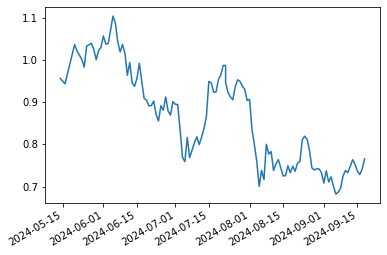

In [27]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [28]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [29]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [30]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT',
       'EGLDUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [31]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [32]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9286
OMUSDT,0.0265
BNBUSDT,0.0202
TRXUSDT,0.0158
PEPEUSDT,0.0043
CKBUSDT,0.0023
JASMYUSDT,0.0023
GALAUSDT,0.0000
WLDUSDT,0.0000
ATOMUSDT,0.0000


In [33]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.462063
BTCUSDT,0.400000
BNBUSDT,0.065678
PEPEUSDT,0.045224
CKBUSDT,0.017202
JASMYUSDT,0.009832


In [34]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [35]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.762266
OMUSDT,0.237734


## Real Portfolio vs Optimal

In [36]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,555.950328,0.293511,0.000000,0.000000
OMUSDT,314.428160,0.166000,0.237734,-0.071734
TRXUSDT,292.582294,0.154467,0.762266,-0.607799
JASMYUSDT,265.836500,0.140347,0.000000,0.000000
SOLUSDT,253.401412,0.133782,0.000000,0.000000
ETHUSDT,170.511259,0.090020,0.000000,0.000000
BBUSDT,41.407818,0.021861,0.000000,0.000000
BNBUSDT,0.022584,0.000012,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [37]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,555.950328,0.293511,0.400000,-0.106489
OMUSDT,314.428160,0.166000,0.462063,-0.296063
TRXUSDT,292.582294,0.154467,0.000000,0.000000
JASMYUSDT,265.836500,0.140347,0.009832,0.130515
SOLUSDT,253.401412,0.133782,0.000000,0.000000
ETHUSDT,170.511259,0.090020,0.000000,0.000000
BBUSDT,41.407818,0.021861,0.000000,0.000000
BNBUSDT,0.022584,0.000012,0.065678,-0.065666
PEPEUSDT,0.000002,0.000000,0.045224,-0.045224
CKBUSDT,0.000000,0.000000,0.017202,0.000000


# Risk Reward Analysis

In [38]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [39]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

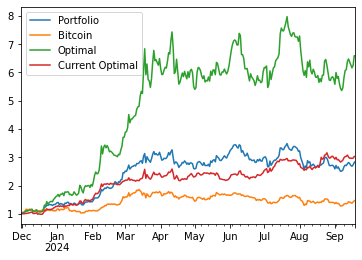

In [40]:
(1+portfolio_perf.iloc[:]).cumprod().plot()

In [41]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

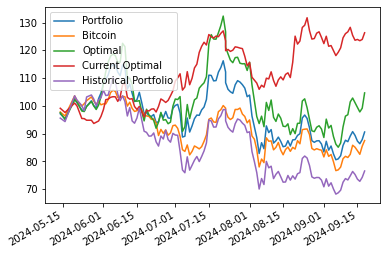

In [42]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [43]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-09,85.781476,81.017786,92.435681,124.507658,72.547158
2024-09-10,87.646156,81.857078,96.310124,125.989080,73.847140
2024-09-11,87.131011,81.432763,96.825303,126.642949,73.353880
2024-09-12,89.145486,82.553132,101.444959,128.269174,74.832363
2024-09-13,90.743994,85.846054,102.832785,125.384868,76.402057
2024-09-14,89.387981,85.126499,101.155299,123.619018,75.325267
2024-09-15,87.338128,83.895897,99.480565,123.911525,73.650513
2024-09-16,86.387726,82.583217,97.822978,123.452809,72.860240
2024-09-17,87.896205,85.509833,99.169987,123.914406,74.288060
2024-09-18,90.605923,87.535703,104.674054,126.305729,76.578064


## Volatilities

In [44]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.718986
dtype: float64

In [45]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.492643
dtype: float64

In [46]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.507303
Bitcoin            0.446647
Optimal            0.720179
Current Optimal    0.408698
dtype: float64

In [47]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2480033905932349

## Risk Contribution

In [48]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.075257,0.065678,0.014335,0.020067,0.002043,0.018024
BTCUSDT,0.193228,0.400000,0.060339,0.158472,0.061542,0.096930
CKBUSDT,0.022162,0.017202,0.004004,0.011903,0.000974,0.010929
JASMYUSDT,0.011641,0.009832,0.002184,0.005400,0.000224,0.005176
OMUSDT,8.444489,0.462063,0.905907,0.767945,0.668491,0.099454
PEPEUSDT,0.084864,0.045224,0.013232,0.036213,0.006649,0.029564


In [49]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.073087,0.237734,0.25819,0.441937,0.378283,0.063653
TRXUSDT,0.130758,0.762266,0.74181,0.558063,0.494410,0.063653


In [50]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.013512,0.292929,0.279885,0.224828,0.063570,0.161258
OMUSDT,0.052791,0.171717,0.224884,0.225545,0.093391,0.132154
TRXUSDT,0.025991,0.151515,0.177803,0.034320,0.009243,0.025077
JASMYUSDT,-0.016283,0.141414,0.125341,0.237767,0.081660,0.156107
SOLUSDT,-0.019115,0.131313,0.112386,0.154559,0.032749,0.121811
ETHUSDT,-0.020810,0.090909,0.070216,0.083587,0.010567,0.073021
BBUSDT,-0.010732,0.020202,0.009485,0.039394,0.003558,0.035836


# Value At Risk

## Historical

In [51]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.059592194663622464, -0.08499752380012725)

In [52]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04698658145339085, -0.06437227487513167)

In [53]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [54]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.016389
OMUSDT      -0.004630
TRXUSDT     -0.003509
JASMYUSDT   -0.006805
SOLUSDT     -0.008930
ETHUSDT     -0.007902
BBUSDT      -0.002242
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050408
Name: 2024-08-27 00:00:00, dtype: float64

In [55]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.014882
OMUSDT      -0.013200
TRXUSDT     -0.003742
JASMYUSDT   -0.014266
SOLUSDT     -0.010323
ETHUSDT     -0.005842
BBUSDT      -0.002118
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.064372
dtype: float64

## Parametric

In [56]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07462210203151501, -0.09564490293585075)

In [57]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.051045682626635724, -0.06542645177774412)

## Multivariate

In [58]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0668701976394653, -0.08579846985679597)

In [59]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.04993895142173297, -0.06320971571757834)

In [60]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.012305
OMUSDT      -0.009278
TRXUSDT     -0.001592
JASMYUSDT   -0.012733
SOLUSDT     -0.008183
ETHUSDT     -0.004495
BBUSDT      -0.001777
Portfolio   -0.050365
dtype: float64

## Copulas

### Gaussian Copula

In [61]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0659193245088234, -0.0851954921513533)

In [62]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05061706404852, -0.06395541133768887)

In [63]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.011633
OMUSDT      -0.010166
TRXUSDT     -0.001839
JASMYUSDT   -0.012501
SOLUSDT     -0.007844
ETHUSDT     -0.004354
BBUSDT      -0.001982
Portfolio   -0.050318
dtype: float64

### Student Copula

In [64]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06626064869459929, -0.08480514305861328)

In [65]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05115059953264699, -0.0659482626141619)

In [66]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.011003
OMUSDT      -0.011321
TRXUSDT     -0.001795
JASMYUSDT   -0.012263
SOLUSDT     -0.008421
ETHUSDT     -0.004216
BBUSDT      -0.002203
Portfolio   -0.051223
dtype: float64

### Gumbel Copula

In [67]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.13645655289338765, -0.19375584696330872)

In [68]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05793168627931718, -0.0780668525451216)

In [69]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010650
OMUSDT      -0.019351
TRXUSDT     -0.001710
JASMYUSDT   -0.016062
SOLUSDT     -0.006869
ETHUSDT     -0.001913
BBUSDT      -0.000961
Portfolio   -0.057515
dtype: float64

### Monte Carlo

In [70]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [71]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07719059412795241, -0.09406625813180192)

In [72]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05212423399635742, -0.06453520127862825)

In [73]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.011264
OMUSDT      -0.011679
TRXUSDT     -0.002111
JASMYUSDT   -0.013115
SOLUSDT     -0.008073
ETHUSDT     -0.003892
BBUSDT      -0.001940
Portfolio   -0.052075
dtype: float64

## VaR Violation

In [74]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.057909,-0.105104,-0.088554,-0.024311
2024-01-15,-0.057909,-0.105101,-0.091730,0.017825
2024-01-16,-0.057909,-0.105681,-0.086459,0.058251
2024-01-17,-0.057909,-0.107988,-0.091744,-0.034481
2024-01-18,-0.057909,-0.109935,-0.096657,-0.032311
...,...,...,...,...
2024-09-15,-0.043316,-0.083186,-0.077792,-0.016556
2024-09-16,-0.043316,-0.083522,-0.080991,-0.016662
2024-09-17,-0.043316,-0.081416,-0.077204,0.013770
2024-09-18,-0.043316,-0.083933,-0.081012,0.055501


In [75]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.028025,-0.078183,-0.072704,-0.017341
2024-05-29,-0.025679,-0.075649,-0.067390,-0.008527
2024-05-30,-0.025679,-0.065625,-0.059137,0.034285
2024-05-31,-0.025679,-0.064377,-0.056807,0.019897
2024-06-01,-0.025679,-0.064905,-0.057366,0.031736
...,...,...,...,...
2024-09-15,-0.036127,-0.065118,-0.064835,-0.022932
2024-09-16,-0.036103,-0.061865,-0.058888,-0.010882
2024-09-17,-0.036103,-0.056202,-0.054774,0.017462
2024-09-18,-0.031974,-0.053405,-0.048977,0.030829


<AxesSubplot:>

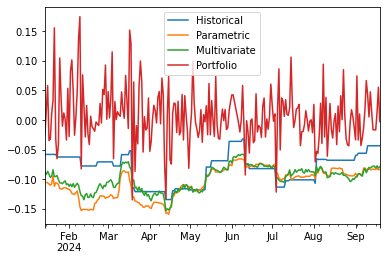

In [76]:
var_data.plot()

<AxesSubplot:>

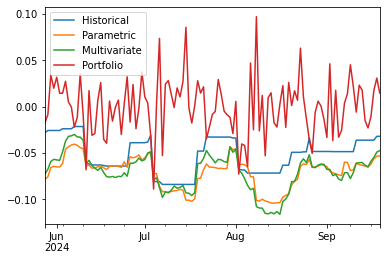

In [77]:
current_var_data.plot()

In [78]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.02,0.012,0.012
Kupiec Stat,6.07148,10.812334,10.812334
P-value,0.013738,0.001008,0.001008


In [79]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.069565,0.026087,0.026087
Kupiec Stat,0.830527,1.665123,1.665123
P-value,0.36212,0.196913,0.196913


## Principal Component Analysis

### Historical PCA

In [80]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78806011, 0.06479275, 0.05309874, 0.04989911, 0.04414929])

In [81]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

1000SATSUSDT    0.023765
AAVEUSDT        0.013983
ADAUSDT         0.014067
ALGOUSDT        0.015614
APTUSDT         0.014920
                  ...   
WLDUSDT         0.021345
XECUSDT         0.015218
XLMUSDT         0.009471
XRPUSDT         0.009095
XTZUSDT         0.014238
Name: PC1, Length: 65, dtype: float64

<AxesSubplot:>

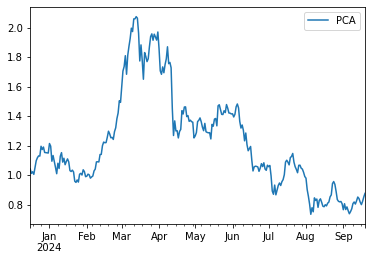

In [82]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

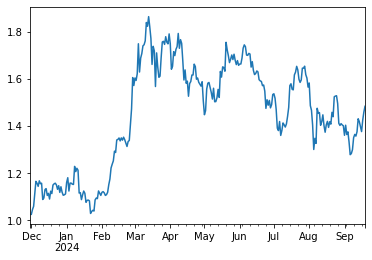

In [83]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [84]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
XTZUSDT      0.336788
ADAUSDT      0.338607
ALGOUSDT     0.350481
ETHUSDT      0.356595
               ...   
PEPEUSDT     0.991194
FLOKIUSDT    1.001356
WLDUSDT      1.023095
CKBUSDT      1.139598
OMUSDT       1.313676
Length: 66, dtype: float64

<AxesSubplot:>

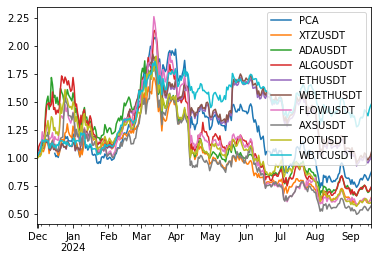

In [85]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

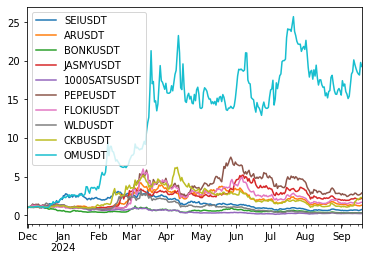

In [86]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [87]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.6682112 , 0.14031406, 0.08838767, 0.07101554, 0.03207153])

In [88]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.064541
OMUSDT       0.100896
TRXUSDT      0.014722
JASMYUSDT    0.154656
SOLUSDT      0.103319
ETHUSDT      0.086416
BBUSDT       0.245893
BNBUSDT      0.068035
PEPEUSDT     0.161521
Name: PC1, dtype: float64

<AxesSubplot:>

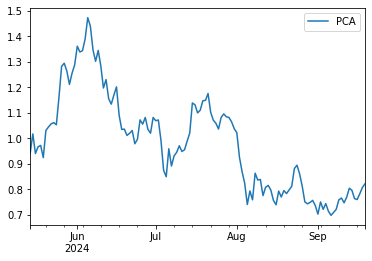

In [89]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

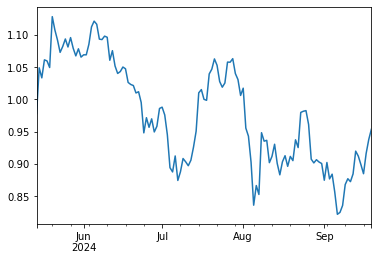

In [90]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [91]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.327337
SOLUSDT      0.339366
BTCUSDT      0.359445
BNBUSDT      0.360597
JASMYUSDT    0.420780
PEPEUSDT     0.454887
OMUSDT       0.532267
TRXUSDT      0.537926
BBUSDT       0.616045
dtype: float64

<AxesSubplot:>

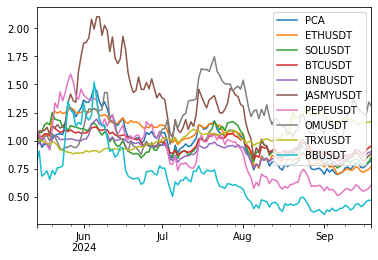

In [92]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [93]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.935551
BBUSDT       1.708756
JASMYUSDT    1.281335
SOLUSDT      1.161647
BTCUSDT      1.000000
OMUSDT       0.992236
ETHUSDT      0.955278
BNBUSDT      0.671177
TRXUSDT      0.278987
Name: BTCUSDT, dtype: float64

In [94]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.454022
BBUSDT       1.286740
ETHUSDT      1.060879
OMUSDT       1.023442
BTCUSDT      1.000000
JASMYUSDT    0.944913
SOLUSDT      0.877937
BNBUSDT      0.673348
TRXUSDT      0.046709
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [95]:
results={}
window=7

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,OMUSDT,TRXUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-20,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2024-05-27,0.000000,0.000000,0.000000,0.405921,0.000000,0.000000,0.122004,0.000000,0.472076
2024-06-03,0.000000,0.814875,0.000000,0.185125,0.000000,0.000000,0.000000,0.000000,0.000000
2024-06-10,0.000000,0.111105,0.841078,0.047817,0.000000,0.000000,0.000000,0.000000,0.000000
2024-06-17,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.020132,0.979868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-07-01,0.000000,0.047122,0.804372,0.000000,0.146827,0.000000,0.001680,0.000000,0.000000
2024-07-08,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-07-15,0.048111,0.000000,0.606760,0.002957,0.000000,0.000000,0.037292,0.304881,0.000000
2024-07-22,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [96]:
(rolling_optimization>0.25).sum()

BTCUSDT      0
OMUSDT       4
TRXUSDT      8
JASMYUSDT    2
SOLUSDT      3
ETHUSDT      0
BBUSDT       1
BNBUSDT      3
PEPEUSDT     1
dtype: int64